# BA 820 Homework 3 (100 Points)

Group Member Names:

Reminder: you should not be sharing code across groups

Please submit 1) PDF answers and 2) python notebook. Grading will be based on the homework answer write up PDF. Python notebook is for reference and back up only. So please make sure that your all the outputs and answers are clearly visible in the pdf.

## 1 Latent Dirichlet Allocation [60pts]

In this problem, we will use Latent Dirichlet Allocation to perform topic modeling on Amazon Review datasets. In particular, we will take an in-depth look at different aspects of LDA model.

## 1.1 Installation

To perform LDA and visualize, please use Python 3.X. You will also need to install Numpy, Scipy, gensim, nltk, pyLDAvis library. Refer to requirements.txt for more details.
Use the following code to install the labraries.

In [14]:
# %pip install gensim
# # install gensim for LDA
# %pip install nltk 
# # install nltk to preprocess sentences
# %pip install pyldavis
# # to visualize LDA topics
# %pip install matplotlib 
# # for plotting

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The cell below tests if the packages we need have been installed correctly, and that we are in the correct environment.

In [14]:
import gensim
import nltk
nltk.download("stopwords")
import pyLDAvis
import matplotlib
%matplotlib inline
import gzip # to unzip the data
import re # to replace punctuations
from nltk.corpus import stopwords # list of stopwords

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryanli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.2 Datasets

You can download the Amazon reviews dataset of Cellphones & Accessory 5-Core Data [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Cell_Phones_and_Accessories_5.json.gz). Place the downloaded dataset in the same folder as this notebook. You can use the following code to read a datat from GZIp file

In [16]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
parse('./reviews_Cell_Phones_and_Accessories_5.json.gz')

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<generator object parse at 0x7fe3a9943270>

## 1.3 Data Cleaning

Now we will preprocess the data using the following steps:
   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

In [17]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    punctuationRegex = r'\W+|\d+'
    stopWords = set(stopwords.words('english'))
    line = line.split(" ")
    filtered_content = []
    for word in line:
        if word not in stopWords:
            if len(word) >= 2:
                word = re.sub(punctuationRegex, '', word)
                filtered_content.append(word.lower())

        #########################
        # YOUR CLEANING CODE HERE
        #########################
    return filtered_content

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finally, we put parse() and clean_line() function together and then extract the first 10,000 reviews into a new text file as your experiment dataset

In [18]:
def read_dataset(fname):
    """ Read the 10000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 10000:
            break
    return exp_dataset

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
%%time
r = read_dataset("reviews_Cell_Phones_and_Accessories_5.json.gz")

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.79 s, sys: 126 ms, total: 1.92 s
Wall time: 1.92 s


## 1.4 Topic Analysis

**[5pts] Q1.4.1.1** Use topic numbers 3, 6, 9, 12, 15 respectively and print out all topics with 5 words.

For this We will use gensim to train an LDA model. gensim requires the following steps:

Construct a gensim.corpora.dictionary from the dataset
Construct a gensim "corpus" using this dictionary, by mapping each word to an index in the dictionary
Run LDA on this corpus

In [20]:
import gensim.corpora as corpora
dictionary = gensim.corpora.Dictionary(r)# create a gensim dictionary, store it in variable "dictionary"
corpus = [dictionary.doc2bow(text) for text in r] # create the gensim corpus, store it in variable "corpus"

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The function below prints the top num words in each topic for a given model.

In [21]:
def print_topic_words(model,num):
    """ print top words in model topics.
    
    Args: 
        model: LDA model
        
    Returns:
        none
    """    
    #########################
    # YOUR CODE HERE
    num_topics = model.num_topics
    for topic_id in range(model.num_topics):
        
        words = model.show_topic(topic_id, num)
        print('Topic #'+str(topic_id))
        print(words)
    print('*'*100)
    return

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The following function builds multiple LDA models with number of topics specified in the list `num_topics`.

In [22]:
def build_num_topic_model(dictionary, corpus, num_topics):
    """ Build lda model with given parameters, use print_topic_words to print words
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        num_topics: list of numbers
        
    Returns:
        none
    """    
    for num_topic in num_topics:
        #########################
        # YOUR CODE HERE
        #   - Build model
        #   - Print the top 5 words
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic)
        print_topic_words(model,5)
        print()
        #########################

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
build_num_topic_model(dictionary, corpus, [3, 6, 9, 12, 15])

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0
[('iphone', 0.049988937), ('case', 0.044588145), ('mophie', 0.029491577), ('pack', 0.016167073), ('battery', 0.015551079)]
Topic #1
[('battery', 0.053863686), ('juice', 0.032217674), ('pack', 0.025239624), ('use', 0.021139733), ('iphone', 0.014763042)]
Topic #2
[('it', 0.011770983), ('', 0.010990056), ('the', 0.010160064), ('one', 0.009855113), ('headset', 0.00896502)]
****************************************************************************************************

Topic #0
[('iphone', 0.060730338), ('case', 0.048411805), ('mophie', 0.036066864), ('pack', 0.030226164), ('juice', 0.017514575)]
Topic #1
[('phone', 0.025212038), ('', 0.009756702), ('it', 0.006486306), ('the', 0.0062855217), ('nokia', 0.005830606)]
Topic #2
[('chore', 0.021735761), ('', 0.016555201), ('phone', 0.016255949), ('the', 0.013253648), ('battery', 0.008088013)]
Topic #3
[('battery', 0.07535601), ('juice', 0.033460412), ('use', 0.022550948), ('packs', 0.022294905), ('addon', 0.017953185)]
Topic #4
[('

**[3pts] Q1.4.1.2**  Explain what could be interpreted for each topics, and describe the similarity and difference between different topic numbers.

From all the topics, we can see that they are related to the product. For example, topic 0 is related to the product's quality, topic 1 is related to the product's price, topic 2 is related to the product's shipping, and topic 3 is related to the product's accessories. The topics are different from each other because the number of topics is different. The more topics, the more detailed the topics are.

**[2pts] Q1.4.1.3**  Which topic number would you choose? Explain.

I would choose topic 3 because it is the most detailed topic. It has the most words in the topic, and the words in the topic are more related to the product.

## 1.5 Model Evaluation

**[12 pts] Q1.5.1** Now we investigate two methods to evaluate our model and choose the topic number

1.Perplexity is a measurement of how well a probability distribution or probability model predicts a sample. A low perplexity indicates the probability distribution is good at predicting the sample. We can use model.log_perplexity(document) to evaluate the perplexity of our LDA model.

2.Topic coherence is a one type of interpretability measurement for a topic. It measures if a set of top keywords describe a coherent and singular concept. A good topic will have high topic coherence score. We can use CoherenceModel(model=ldamodel).get_coherence() to calculate it.

Plot Perplexity and topic coherence scores of our LDA model for topic number 3,6,9,12,15,20,50.

The code below trains topic models with different numbers of topics and measures their coherence and perplexity.

In [62]:
# perplexity 
# run different number of topics to get perplexity and coherence value for this model
from gensim.models.coherencemodel import CoherenceModel
def get_measurement_for_model(dictionary, corpus, topic_nums):
    """ Build lda model with given parameters 
    
    Args: 
        dictionary: dictionary built from dataset
        corpus: corpus built from dataset
        topic_nums: a list contains all possible topic number
        
    Returns:
        2 lists: one of perplexities, and one of coherence value
    """  
    perplexity = []
    coherence_value=[]
    for num_topic in topic_nums:
        #########################
        # YOUR CODE HERE
        #   - Build model
        #   - Compute and store coherence
        #   - Compute and store perplexity
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topic)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=r, dictionary=dictionary, coherence='c_v')
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_value.append(coherence_lda)
        perplexity.append(lda_model.log_perplexity(corpus))
        #########################
    return perplexity,coherence_value

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [63]:
perplexity, coherence = get_measurement_for_model(dictionary, corpus, [3, 6, 9, 12, 15, 20, 50])

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
print(perplexity)
print(coherence)

[-7.989182071149332, -8.390229442833055, -8.346125040279292, -8.633199534861175, -8.83779426863714, -9.140899563844522, -10.91491858770547]
[0.2903301449275196, 0.2765158146490121, 0.28660017179148223, 0.26913343896078196, 0.27619421568994695, 0.2801812799751062, 0.3010712490269261]


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can now plot the coherence and perplexity of each model.

In [27]:
import matplotlib.pyplot as plt

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


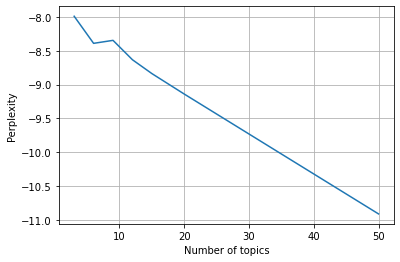

In [65]:
plt.plot([3, 6, 9, 12, 15, 20, 50], perplexity)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Perplexity")
plt.show()

**[2pts] Q1.5.2**  From the above graph what topic number would you choose and why? Is it a good idea to choose the topic number based on perplexity? why or why not?

I would choose 50 because it has the lowest perplexity. It is a good idea to choose the topic number based on perplexity because it is a measurement of how well a probability distribution or probability model predicts a sample. A low perplexity indicates the probability distribution is good at predicting the sample. However, coherence is also important because it measures if a set of top keywords describe a coherent and singular concept. A good topic will have high topic coherence score.

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


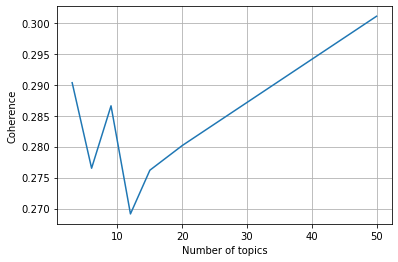

In [66]:
plt.plot([3, 6, 9, 12, 15, 20, 50], coherence)
plt.grid()
plt.xlabel("Number of topics")
plt.ylabel("Coherence")
plt.show()

**[2pts] Q1.5.3**  From the above graph what topic number would you choose and why?

I will choose 50 because it has the highest coherence. It is a good idea to choose the topic number based on coherence because it measures if a set of top keywords describe a coherent and singular concept. A good topic will have high topic coherence score.

**[4pts]Q1.5.4** Compare two methods you implemented in the previous quesions, which one do you think is better and why? In answering, please discuss the actual topics generated.

I would choose 50 because it has the highest coherence even though it is not the lowest perplexity. The both features are important. The coherence is more important than the perplexity because the coherence is a measurement of interpretability.

## 1.6 Alpha and Beta in LDA

**[7pts]Q1.6.1** In this problem, we will check the two most important parameters in LDA model: alpha and beta. Alpha represents document-topic density - with a higher alpha, documents are made up of more topics, and with lower alpha, documents contain fewer topics. Beta represents topic-word density - with a high beta, topics are made up of most of the words in the corpus, and with a low beta they consist of few words.

In [67]:
best_topic_num = 50 # CHANGE THIS

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
#model 1
#########################
# YOUR CODE HERE
#   - Build model for alpha = 1/num_topic = eta
#   - Print top words
model1 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_topic_num, alpha=1/best_topic_num, eta=1/best_topic_num)
print_topic_words(model1,5)
#########################

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0
[('n', 0.08150391), ('original', 0.031707175), ('good', 0.022617655), ('works', 0.021976823), ('price', 0.011978005)]
Topic #1
[('lacks', 0.015647171), ('thicker', 0.011835372), ('tips', 0.011807772), ('igo', 0.011707211), ('sync', 0.010087838)]
Topic #2
[('phone', 0.015390878), ('the', 0.011762522), ('', 0.009820316), ('led', 0.0087164985), ('it', 0.007119962)]
Topic #3
[('battery', 0.023713734), ('pod', 0.014484513), ('the', 0.009952275), ('old', 0.009927774), ('it', 0.00966524)]
Topic #4
[('pack', 0.033400457), ('mirror', 0.027951114), ('screens', 0.020829944), ('the', 0.013018089), ('wonderful', 0.008920175)]
Topic #5
[('phone', 0.026403463), ('', 0.0183843), ('the', 0.017029699), ('it', 0.009529888), ('get', 0.008001397)]
Topic #6
[('phone', 0.018074982), ('one', 0.017590076), ('velcro', 0.01044999), ('n', 0.009737546), ('duty', 0.0082156975)]
Topic #7
[('juice', 0.49867427), ('air', 0.052546278), ('extra', 0.025661541), ('for', 0.022732276), ('use', 0.022527141)]
Topic #

In [69]:
#model 2
model2 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_topic_num, alpha=1/2, eta=1/5)
print_topic_words(model2,5)
#########################
# YOUR CODE HERE
#   - Build model for alpha = 1/2, eta = 1/5
#   - Print top words
#########################

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0
[('phone', 0.0020630762), ('encumbered', 0.0017770107), ('beefs', 0.0017770107), ('attachedif', 0.0017770107), ('effectly', 0.0017770107)]
Topic #1
[('the', 0.0033137626), ('it', 0.0032906923), ('', 0.0030425761), ('phone', 0.0027707843), ('one', 0.002485853)]
Topic #2
[('works', 0.015176524), ('it', 0.013756396), ('phone', 0.011935157), ('one', 0.011423237), ('cable', 0.009912332)]
Topic #3
[('one', 0.0027666225), ('great', 0.0022899495), ('works', 0.0020769553), ('price', 0.0018719853), ('phone', 0.0017766245)]
Topic #4
[('it', 0.00316266), ('', 0.00276303), ('encumbered', 0.0017132206), ('attachedif', 0.0017132206), ('effectly', 0.0017132206)]
Topic #5
[('beefs', 0.0018398087), ('effectly', 0.0018398087), ('encumbered', 0.0018398087), ('attachedif', 0.0018398087), ('phone', 0.0016889035)]
Topic #6
[('it', 0.002437534), ('great', 0.0019352613), ('phone', 0.0019272502), ('effectly', 0.0018195558), ('attachedif', 0.0018195558)]
Topic #7
[('it', 0.003038537), ('phone', 0.002063

In [70]:
#model 3
model3 = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=best_topic_num, alpha='auto', eta='auto')
print_topic_words(model3,5)
#########################
# YOUR CODE HERE
#   - Build model for alpha = 'auto' = eta
#   - Print top words
#########################

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0
[('sound', 0.013278967), ('volume', 0.012559377), ('the', 0.012189787), ('phone', 0.012028249), ('use', 0.011045517)]
Topic #1
[('money', 0.058521584), ('waste', 0.04960528), ('products', 0.023518553), ('dont', 0.010306245), ('substantial', 0.009119033)]
Topic #2
[('headset', 0.031820837), ('ear', 0.023353124), ('bluetooth', 0.014992564), ('it', 0.014128464), ('the', 0.011986177)]
Topic #3
[('film', 0.029222833), ('working', 0.020304462), ('stopped', 0.015819212), ('son', 0.014162653), ('de', 0.01260207)]
Topic #4
[('shed', 0.22354925), ('chore', 0.22019887), ('use', 0.02715837), ('wearing', 0.024033561), ('level', 0.016640743)]
Topic #5
[('phone', 0.04257497), ('cell', 0.018748699), ('would', 0.013342376), ('it', 0.012241454), ('get', 0.011436115)]
Topic #6
[('storm', 0.054942194), ('it', 0.009334485), ('showing', 0.008398844), ('juice', 0.007539291), ('use', 0.007262647)]
Topic #7
[('phone', 0.027792059), ('it', 0.015685914), ('juice', 0.012450253), ('work', 0.008462263), ('

**[3pts]1.6.2**  Explain how the different alpha and beta values theoretically influence the LDA model. Then describe what you find in the empirical result (e.g difference in topic words and topics)

 The higher alpha and beta, the more topics and words in the topic. The lower alpha and beta, the less topics and words in the topic.
 In the first model when both are low, it has less topics but model 2 has more compare to model 1. Same come to model 3, it has more than model1.

## 1.7 LDA on a short text dataset

**[10pts]1.7.1** In this part, we will read a dataset from twitter and build a LDA model. On Windows, download and unzip the dataset from [this link](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip). Place the downloaded dataset in the same folder as this notebook. Use the first 10,000 lines in the "training.1600000.processed.noemoticon.csv" file. 

In [34]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip # Linux and OSX only
!unzip trainingandtestdata.zip # Linux and OSX only

zsh:1: command not found: wget
unzip:  cannot find or open trainingandtestdata.zip, trainingandtestdata.zip.zip or trainingandtestdata.zip.ZIP.


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
!head -n 10000 training.1600000.processed.noemoticon.csv > twitter.csv # Linux and OSX only

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
def read_twitter(fname):
    """ Read the given dataset into list and clean stop words. 
    
    Args: 
        fname (string): filename of Twitter Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
  
    twitter = []
    with open(fname,encoding="utf-8") as f:
        for line in f:
            tweet = f.readline().split(",")[5]
            
            stopWords = set(stopwords.words('english'))
            tweet = tweet.split(" ")
            clean_tweet = []
            punctuationRegex = r'\W+|\d+'
            for w in tweet:
                w = w.lower()
                if w not in stopWords:
                    w = re.sub(punctuationRegex, ' ', w)
                    if len(w) >= 2:
                        clean_tweet.append(w)
           
            twitter.append(clean_tweet)




            ########################
            # YOUR CLEANING CODE HERE
            ########################
    return twitter

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
%%time
twitter = read_twitter('twitter.csv')

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 408 ms, sys: 53.1 ms, total: 461 ms
Wall time: 460 ms


In [38]:
twitter_dictionary = gensim.corpora.Dictionary(twitter) # TODO: build dictionary
twitter_corpus = [twitter_dictionary.doc2bow(text) for text in twitter] # TODO: build corpus for model

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
%%time
########################
# YOUR CODE HERE
#    - Build model
#    - Print top words
t_model = gensim.models.ldamodel.LdaModel(corpus=twitter_corpus, id2word=twitter_dictionary, num_topics=5)
print_topic_words(t_model,5)
########################

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic #0
[(' is', 0.009836194), ('i m', 0.007289609), ('like', 0.006140389), ('work', 0.0052561504), ('still', 0.004966049)]
Topic #1
[(' i', 0.010554), ('i m', 0.010124678), ('think', 0.005957), ('like', 0.0052914284), ('want', 0.0049571455)]
Topic #2
[('get', 0.007398168), ('night', 0.0073218886), ('home', 0.0059108683), ('today ', 0.005856536), ('last', 0.0058111106)]
Topic #3
[(' i', 0.012295593), ('work', 0.011885202), ('go', 0.009249411), ('got', 0.0088013075), ('miss', 0.0075263306)]
Topic #4
[(' i', 0.009341358), ('get', 0.009163124), ('go', 0.008256394), ('need', 0.007435016), ('work', 0.00628568)]
****************************************************************************************************
CPU times: user 1.29 s, sys: 4.52 ms, total: 1.29 s
Wall time: 1.29 s


## 1.8 LDA visualization

**[10pts]1.8.1** We will now visualize the LDA output using pyLDAvis. PyLDAVis shows the following:

   1. The distances between topics, as a map in 2-D space.
   2. The variance in the topic-word distribution, as the size of a circle in this map.
   3. The most "salient" terms in each topic.

In [40]:
sentences = read_dataset("reviews_Cell_Phones_and_Accessories_5.json.gz")[:1000] # CHANGE TO YOUR DATASET

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
%%time
import pyLDAvis.gensim
import pyLDAvis.gensim_models

CPU times: user 4.04 ms, sys: 2.88 ms, total: 6.92 ms
Wall time: 8.23 ms


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
%%time
data = None
########################
# YOUR CODE HERE
#   - Initalize pyLDAvis with your model
#   - Make sure to use a subset of the sentences in the dataset
#     if your pyLDAvis call in the cell below is taking too long
########################
sentences_dictionary = gensim.corpora.Dictionary(sentences) # TODO: build dictionary
sentences_corpus = [sentences_dictionary.doc2bow(text) for text in sentences] # TODO: build corpus for model
sentences_model = gensim.models.ldamodel.LdaModel(corpus=sentences_corpus, id2word=sentences_dictionary, num_topics=5) # TODO: build model

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.05 s, sys: 11.6 ms, total: 1.06 s
Wall time: 1.06 s


In [43]:
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim_models.prepare(sentences_model, sentences_corpus, sentences_dictionary)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [44]:
pyLDAvis.enable_notebook()
pyLDAvis.display(data)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2.word2Vec [40pts]


In this problem, we use Amazon Review Dataset to perform Word2Vec and Doc2Vec to extract insights relevant for e-commerce business. For this question, download and use the dataset [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Electronics_5.json.gz||reviews_Electronics_5.json.gz).

## 2.1 Data Cleaning



The following code reads the data from a GZIP file.

In [22]:
# A function to read the zipped data at a specfic path
#
# How to use:
# PATH = "/path/to/file"
# for line in parse(PATH):
#   do something with line
#
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We will now read the data and preprocess it using the following steps:

   1. Remove stopwords
   2. Lower-case all words
   3. Remove words with less than 2 characters
   4. Remove punctuation
   5. Split each sentence into a list of words

   And finally extract 10000 reviews.

In [23]:
# A function to clean a single line of text
def clean_line(line):
    """ Clean stopwords and punction for each line
    
    Args: 
        line (string): one line in file
        
    Returns:
        list(str): a list of all words in the sentence
    """
    punctuationRegex = r'\W+|\d+'
    stopWords = set(stopwords.words('english'))
    line = line.split(" ")
    filtered_content = []
    
    for word in line:
        if word not in stopWords:
            if len(word) > 2:
                filtered_content.append(word.lower()) 
    filtered_content = [re.sub(punctuationRegex, '',word) for word in filtered_content] 
    return filtered_content

def read_dataset(fname):
    """ Read the 100000 lines in given dataset into list and clean stop words. 
        
    Args: 
        fname (string): filename of Amazon Review Dataset
        
    Returns:
        list of list of words: we view each document as a list, including a list of all words 
    """
    count = 0
    exp_dataset = []
    for review in parse(fname):
        line = review["reviewText"]
        new_line = clean_line(line)
        exp_dataset.append(new_line)
        count += 1
        if count > 100000:
            break
    return exp_dataset    

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
%%time
r = read_dataset("reviews_Electronics_5.json.gz")

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 23.5 s, sys: 1.58 s, total: 25.1 s
Wall time: 25.2 s


## 2.2 Build a doc2vec model

**[3pts]2.2.1** In this question, first we will build a Word2Vec model using ginsim using size=300, min_count=40, win- dow=10, negative=10, max_vocab_size=10000. Train the model for 30 epochs.

In [25]:
from gensim.models import Word2Vec
# YOUR CODE HERE
w2v = Word2Vec(r, vector_size=300, min_count=40, window=10, negative=10, max_vocab_size=10000, workers=4, epochs=30)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**[2pts]2.2.2** Use model.wv.doesnt_match to find a word in ["Canon","Nikon","junk"] that does not

belong.

In [49]:
# YOUR CODE HERE 
words = ["Canon", "Nikon", "junk"]
dmwords = w2v.wv.doesnt_match(words)
print(f"The word that does not belong is: {dmwords}")

The word that does not belong is: junk


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**[3pts]2.2.3** Come up with 3 other word lists and apply the above function. Explain your observation.

In [50]:
words = ["camera", "IPhone", "bottle"]
dmwords = w2v.wv.doesnt_match(words)
print(f"The word that does not belong is: {dmwords}")

The word that does not belong is: camera


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Bottle is the only non electronic item in the list.

**[2pts]2.2.4** What are some tasks in e-commerce that can be solved with this simple function?

In e-commerce, the above w2v model and doesnt_match function can be used for item categorization and similiar product recommendations to increase sales.

## 2.3 Build a doc2vec model

**[15 pts] 2.3.1**  Each review is marked by other customers as “helpful” or not. The "helpful: [a, b]" item in each review is (a) the number of people who marked the review as helpful, and (b) the total number of people who have marked the review as helpful or unhelpful. The "helpfulness" score of a review can be calculated as a/b. Define a "helpful" review as one with helpfulness score >= 0.8. Given a review that is only slightly helpful, could we find textually similar reviews but have higher helpfulness? Build Doc2Vec model with gensim on review data. Use product ID “B00006I5WJ” and ReviewerID with “A14453U0KFWF31” as an example, find top 5 helpful reviews of the same product with similarity score above 0.8. 

In [5]:
import os
def read_reviewers_data(fname, min_count=0):
    '''
    Save all reviews into their own product asin files.
    Make sure you have 'product' folder when you run this answer.
    In each file, you can choose your own log structure. In this answer, log strucutre is like 
        "reviewText"\t"reviewerID"\t"helpful"
    Args: 
        fname: dataset file path
        min_count: minimum number of reviews of a product
    Returns:
        none
    '''
    if not os.path.isdir('product'):
        os.makedirs('product')
    asin_list = []
    tmp_list = []
    last_asin = ""
    j = 0
    for i in parse(fname):
        if last_asin != i['asin']:
            if len(tmp_list) > min_count:
                f = open("product/" + last_asin+".txt", 'w')
                for one in tmp_list:
                    f.write(one)
                f.close()
            tmp_list = []
            last_asin = i['asin']
        tmp_list.append(i["reviewText"] + '\t' + i["reviewerID"] +
                    '\t' + handle_helpful(i["helpful"]) + "\n")
        j += 1
        if j > 100000:
            break
            
def handle_helpful(helpful):
    '''
    Helper function for helpful_score calculate
    Args: 
        helpful: list. The first element is the number of people think this is helpful. The second element
            is the total number of people evaluate this comment
    Returns:
        String: number represent helpfulness
    '''
    if helpful[1] != 0:
        helpfulness = 1.0 * helpful[0] / helpful[1]
        return str(helpfulness)
    else:
        return str(0)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
read_reviewers_data("reviews_Electronics_5.json.gz")

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
class TaggedReviewDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, dirname):
        self.dirname = dirname
        self.helpfulness = {}  # key:reviewerID value:helpfulness
        self.product = {}      # key:asin value:reviewerID
        self.asin = []

    def __iter__(self):
        for filename in os.listdir(self.dirname):
            asin_code = filename[:-4] #delete ".txt"
            self.product[asin_code] = []
            self.asin.append(asin_code)
            for line in enumerate(open(self.dirname + "/" + filename)):
                line_content = line[1].split("\t")
                self.product[asin_code].append(line_content[1])
                self.helpfulness[line_content[1]] = float(line_content[2])
                yield TaggedDocument(clean_line(line_content[0]), [line_content[1], line_content[2]])


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
documents = TaggedReviewDocument("product")

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
%%time
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
# YOUR CODE HERE
d2v = Doc2Vec(documents, window = 3, workers = 2,vector_size =3, min_count=5 )

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 5min 28s, sys: 28.9 s, total: 5min 57s
Wall time: 5min 2s


## Find similar reviews

In [59]:
def find_similar_reviews(asin,reviewer_id):
    '''
    If one review is similar to the specefic review and it is much helpful, save it to a list
    Args: 
        asin: product asin
        reviewer_id: the specific review
    Returns:
        list of reviewer id
    '''
    result = []
    ########################
    # YOUR CODE HERE
    ########################
    
    vector = d2v.infer_vector([asin, reviewer_id])    
    product_vecs = d2v.docvecs
    similarity = d2v.docvecs.most_similar([vector], topn=len(product_vecs))

    r_id_list = []
    
    for i in documents.product[asin]:
        if d2v.docvecs.similarity(reviewer_id,i) > 0.8 and i != reviewer_id:
            r_id_list.append(i)
    
    h_list = []
    for i in r_id_list:
        h_list.append((i,documents.helpfulness[i]))
    
    result = sorted(h_list, key=lambda x: x[1], reverse=True)[:5]
            
    return result


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
print(find_similar_reviews("B00006I5WJ", "A14453U0KFWF31")) 

[('A2IXUSSQ4KJEAX', 1.0), ('A1ZJSYEQQDIDAA', 1.0), ('AGITH5SMFTBOB', 1.0), ('A5C7KD02LS69I', 1.0), ('A1MSY5U64K1Y3D', 1.0)]


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-59-3a4a219117bf>:16: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  product_vecs = d2v.docvecs
<ipython-input-59-3a4a219117bf>:17: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similarity = d2v.docvecs.most_similar([vector], topn=len(product_vecs))
<ipython-input-59-3a4a219117bf>:22: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  if d2v.docvecs.similarity(reviewer_id,i) > 0.8 and i != reviewer_id:
<ipython-input-59-3a4a219117bf>:22: DeprecationWarni

## 2.4 Build a doc2vec model using product descriptions


**[10pts]2.4.1** Use product descriptions (located in meta data  [here](http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Electronics.json.gz)) to build a Doc2Vec model. When building the doc2vec model, use vector_size=100, window=15, min_count=5, max_vocab_size=1000, and train it for 1 epoch.

In [7]:
def read_product_description(fname):
    '''
    Load all product descriptions
    Args: 
        fname: dataset file path
    Returns:
        dict: key is asin, value is description content
    '''
    result = {}
    for i in parse(fname):
        try:
            if "Camera & Photo" in i["categories"][0]:
                result[i["asin"]]=i["description"]
        except:
            continue
    return result

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
class TaggedDescriptionDocument(object):
    '''
    This class could save all products and review information in its dictionary and generate iter for TaggedDocument
        which could used for Doc2Vec model
    '''
    def __init__(self, descriptondict):
        self.descriptondict = descriptondict
        

    def __iter__(self):
        for asin in self.descriptondict:
            for content in self.descriptondict[asin]:
                yield TaggedDocument(clean_line(content), [asin])


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
description_dict = read_product_description("meta_Electronics.json.gz")
des_documents = TaggedDescriptionDocument(description_dict)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Build a doc2vec model
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

model = Doc2Vec(vector_size=100, window=15, min_count=5, max_vocab_size=1000, epochs=1)


/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
model.build_vocab(des_documents)

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.train(des_documents, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
pip install 

**[5pts]2.4.2** Find the most similar product for Canon EOS 5D (asin:B0007Y791C) not made by Canon.

In [21]:
most_similar_products = model.dv.most_similar(positive=[model.dv['B0007Y791C']],negative = 'canon', topn=5)

for asin in most_similar_products:
    print(f"ASIN: {asin} ,Description: {des_documents.descriptondict[asin[0]]}")

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "Key 'canon' not present in vocabulary"

In [19]:
most_similar_products = model.dv.most_similar(positive=[model.dv['B0007Y791C']], topn=5)

for asin in most_similar_products:
    print(f"ASIN: {asin} ,Description: {des_documents.descriptondict[asin[0]]}")


ASIN: ('B0007Y791C', 1.0) ,Description: World's smallest and lightest full-frame digital SLR as of August 2005 the sensor operates without a conversion factor.New larger 2.5-inch LCD screen can be viewed even at extreme angles of up to 170 degrees.New larger 2.5-inch LCD screen can be viewed even at extreme angles of up to 170 degrees.Consecutive shooting allows the capture of 3.0 frames per second for up to 60 consecutive JPEG or 17 RAW frames in a burst.
ASIN: ('B001BP1YEE', 0.4226471781730652) ,Description: Why Choose? Why Settle? Introducing the New Kata 3N1!Why choose between a backpack and a sling when you simply can pick up one of the new Kata 3N1 bags and get the best features of each type of bag? These unique bags provide ultimate freedom designed with three carrying options in one bag: right-handed sling, left-handed sling and backpack. Quick access to a camera has never been faster with a sling that offers a quick release and one-handed bag opening for camera access. Left-ha

/Users/ryanli/opt/miniconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Based on the above result, the most similar product is B001BP1YEE